# Long Term Care - Development of Life Expectancy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class MarkovChain():
    def __init__(self, nr_of_states, start_age, end_age, reduction_in_mortality, man_or_woman = 0):
        self.MAX_AGE = 100
        self.MIN_AGE = 0
        self.MAX_TIME = 126
        self.interest_rate = 0.04
        self.nr_of_states = nr_of_states
        self.start_age = start_age
        self.end_age = end_age
        self._pij = [np.zeros([self.nr_of_states, self.nr_of_states]) for i in range(self.MAX_TIME)]
        self.benefit = [np.zeros(self.nr_of_states) for i in range(self.MAX_TIME)]
        self.post = [np.zeros([self.nr_of_states, self.nr_of_states]) for i in range(self.MAX_TIME)]
        self.premium_due = [np.zeros(self.nr_of_states) for i in range(self.MAX_TIME)]
        self.deckungskapital = [-1 * np.ones([nr_of_states, self.MAX_TIME]) for i in range(self.MAX_TIME)]
        #annuities will be set negatives, so we start the array positive
        self.expected_annuities = [np.ones([nr_of_states, self.MAX_TIME]) for i in range(self.MAX_TIME)]
        self.reduction_in_mortality = reduction_in_mortality
        self.male_or_female = man_or_woman
        
        self.__import_data__()
        
        self.calculate_model()
        
    def __import_data__(self):
        PIJ_FILE = 'pij.dat'
        POST_FILE = 'post.dat'
        PRE_FILE = 'pre.dat'
        PRE_PREMIUM_FILE = 'PrePrem1.dat'
        ZINS_FILE = 'zins.dat'
        
        #import transition data (probabilities)
        pij = np.loadtxt(PIJ_FILE)
        for i in range(pij.shape[0]):
            self._pij[int(pij[i,0])] [int(pij[i,1]),int(pij[i,2])] = pij[i,3]
            
        #set pre benefits
        for i in range(self.MAX_TIME):
            j = 3
            self.benefit[i][j] = 6000.
            for j in range(4,8):
                self.benefit[i][j] = 12000.
        
        #import post pattern (all zero)
        #remains all zero

        #import pre premium
        premium_due = np.loadtxt(PRE_PREMIUM_FILE)
        for i in range(premium_due.shape[0]):
            self.premium_due[int(premium_due[i,0])][int(premium_due[i,1])] = premium_due[i,3]
            
    def model_name(self):
        if self.reduction_in_mortality == 0:
            return 'static_'
        if self.reduction_in_mortality == 0:
            return 'single_reduction_'
        return 'double_reduction_'
            
            
    def discount_rate(self, t):
        return 1. / (1. + self.interest_rate)

    def get_pij(self, age, i, j, t=0):
        if self.reduction_in_mortality > 0 and t > 0:
            if i > 3 and self.reduction_in_mortality == 2:
                reduction = np.exp(2*self.mortality_reduction(age, self.male_or_female)*t)
            else:
                reduction = np.exp(self.mortality_reduction(age, self.male_or_female)*t)
            if j == 0:
                if self._pij[age][i, j] == 1:
                    return self._pij[age][i, j]
                return self._pij[age][i, j] * reduction
            return self._pij[age][i, j] * (1 - reduction * self._pij[age][i, 0]) / (1 - self._pij[age][i, 0])
        return self._pij[age][i, j]
    
    def get_deckungskapital(self, age, j, time=0):
        if self.deckungskapital[age][j, time] < 0:
            if age >= self.MAX_AGE:
                self.deckungskapital[age][j, time] = 0
            else:
                self.deckungskapital[age][j, time] = self.benefit[age][j]
                for k in range(self.nr_of_states):
                    self.deckungskapital[age][j, time] +=\
                    self.discount_rate(0)*self.get_pij(age, j, k, time)*\
                    (self.post[age][j,k]+self.get_deckungskapital(age + 1, k, time + 1))
        return self.deckungskapital[age][j, time]
        
    def get_expected_annuities(self, age, j, time=0):
        if self.expected_annuities[age][j, time] > 0:
            if age >= self.MAX_AGE:
                self.expected_annuities[age][j, time] = 0
            else:
                self.expected_annuities[age][j, time] = self.premium_due[age][j]
                for k in range(self.nr_of_states):
                    self.expected_annuities[age][j, time] +=\
                    self.discount_rate(0)*self.get_pij(age, j, k, time)*\
                    self.get_expected_annuities(age + 1, k, time + 1)
        return self.expected_annuities[age][j, time]
    
    def premium(self, age, j):
        if self.get_expected_annuities(age, j) == 0:
            return 0.
        return self.get_deckungskapital(age, j) / self.get_expected_annuities(age,j)
    
    def mathematical_reserves(self, age, j, time = 0):
        return self.get_deckungskapital(age, j, time) - self.get_expected_annuities(age, j, time)*self.premium(self.start_age, j)
    
    def calculate_model(self):
        #if True: return
        for age in range(self.MAX_AGE, self.MIN_AGE-1,-1):
            for j in range(self.nr_of_states):
                self.get_deckungskapital(age, j)
                self.get_expected_annuities(age, j)
     
    def mortality_reduction(self, age, male_or_female):
        if age > 104: 
            return 0.
        original_data = []
        original_data.append([-0.0376, -0.0359])
        original_data.append([-0.0373, -0.0327])
        original_data.append([-0.0339, -0.0279])
        original_data.append([-0.0274, -0.0216])
        original_data.append([-0.0185, -0.0160])
        original_data.append([-0.0096, -0.0125])
        original_data.append([-0.0042, -0.0109])
        original_data.append([-0.0037, -0.0113])
        original_data.append([-0.0078, -0.0132])
        original_data.append([-0.0143, -0.0159])
        original_data.append([-0.0207, -0.0184])
        original_data.append([-0.0250, -0.0199])
        original_data.append([-0.0272, -0.0206])
        original_data.append([-0.0278, -0.0205])
        original_data.append([-0.0270, -0.0198])
        original_data.append([-0.0245, -0.0184])
        original_data.append([-0.0205, -0.0164])
        original_data.append([-0.0153, -0.0133])
        original_data.append([-0.0099, -0.0095])
        original_data.append([-0.0053, -0.0058])
        original_data.append([-0.0020, -0.0028])
        original_data.append([ 0.0000,  0.0000])
        r = (age % 5) / 5.
        return original_data[age//5][male_or_female]*(1-r) + original_data[(age//5) + 1][male_or_female] * r
    
    def savings_premium(self, age, status):
        return self.discount_rate(0)*self.mathematical_reserves(age + 1, status, 1) - self.mathematical_reserves(age, status, 0)
    
    def risk_premium(self, age, status):
        return self.premium(self.start_age, status) - self.savings_premium(age, status)
    
    #PLOTS
                       
    def plot_deckungskapital(self):
        x = [i for i in range(self.start_age, self.end_age + 1)]
        fig, ax = plt.subplots()
        plts = []
        for j in range(1, self.nr_of_states):
            y = [self.get_deckungskapital(age, j) for age in x]
            plts.append(ax.plot(x,y)[0])
        ax.grid()
        lgd = ax.legend((p for p in plts),\
                  ('Healthy', 'DLA-1', 'DLA-2', 'DLA-3', 'DLA-4', 'DLA-5', 'DLA-6', 'DLA-7'),\
                  bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.set_title('Covering Capital per Health Status')
        plt.savefig(self.model_name() + 'coveringcapital.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)
        
    def plot_mathematical_reserves(self):
        x = [i for i in range(self.start_age, self.end_age + 1)]
        fig, ax = plt.subplots()
        plts = []
        for j in range(1, self.nr_of_states):
            y = [self.mathematical_reserves(age, j) for age in x]
            plts.append(ax.plot(x,y)[0])
        ax.grid()
        lgd = ax.legend((p for p in plts),\
                  ('Healthy', 'DLA-1', 'DLA-2', 'DLA-3', 'DLA-4', 'DLA-5', 'DLA-6', 'DLA-7'),\
                  bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.set_title('Mathematical Reserves per Health Status')
        plt.savefig(self.model_name() + 'mathematicalreserves.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)
        
    
    def plot_premium(self):
        x = [i for i in range(self.start_age, self.end_age + 1)]
        fig, ax = plt.subplots()
        plts = []
        y1 = [self.premium(age, 1) for age in x]
        plts.append(ax.plot(x,y1)[0])
        y2 = [self.premium(age, 2) for age in x]
        plts.append(ax.plot(x,y2)[0])
        ax.grid()
        lgd = ax.legend((p for p in plts), ('Healthy', 'DLA-1'), bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.set_title('Premium')
        plt.savefig(self.model_name() + 'premium.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

    def plot_premium_split(self):
        x = [i for i in range(self.start_age, self.end_age)]
        fig, ax = plt.subplots()
        plts = []
        plts.append(ax.plot(x, [self.premium(self.start_age, 1) for age in x], 'g-')[0])
        plts.append(ax.plot(x, [self.risk_premium(age, 1) for age in x], 'g--')[0])
        plts.append(ax.plot(x, [self.savings_premium(age, 1) for age in x], 'g:')[0])
        plts.append(ax.plot(x, [self.premium(self.start_age, 2) for age in x], 'b-')[0])
        plts.append(ax.plot(x, [self.risk_premium(age, 2) for age in x], 'b--')[0])
        plts.append(ax.plot(x, [self.savings_premium(age, 2) for age in x], 'b:')[0])
        ax.grid()
        lgd = ax.legend((p for p in plts), ('Healthy', 'Healthy RP', 'Healthy SP',\
                    'DLA-1', 'DLA-1 RP', 'DLA-1 SP'),\
                  bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.set_title('Premium for Healthy and DLA-1 Insureds')
        plt.savefig(self.model_name() + 'premiumsplit.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)
        
    def plot_pij(self):
        x = [i for i in range(self.start_age, self.end_age + 1)]
        fig, ax = plt.subplots()
        plts = []
        for j in [1, 2, 3, 4, 5, 6, 7]:
            y = [self.get_pij(age, j, 0) for age in x]
            plts.append(ax.plot(x,y)[0])
        ax.grid()
        lgd = ax.legend((p for p in plts),\
                  ('Healthy', 'DLA-1', 'DLA-2', 'DLA-3', 'DLA-4', 'DLA-5', 'DLA-6', 'DLA-7'),\
                  bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.set_title('Death Probability')
        plt.savefig(self.model_name() + 'deathprobability.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)
        
    def plot_mortality_reduction(self):
        x = [i for i in range(0, 106, 1)]
        fig, ax = plt.subplots()
        plts = []
        plts.append(ax.plot(x, [self.mortality_reduction(i, 0) for i in x])[0])
        plts.append(ax.plot(x, [self.mortality_reduction(i, 1) for i in x])[0])
        ax.grid()
        lgd = ax.legend((p for p in plts), ('Men', 'Women'), bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.set_title('Mortality Reduction')
        plt.savefig(self.model_name() + 'mortalityreduction.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)
        
    #TABLES
    
    def print_mortality_reduction(self):
        d={"Age": [i for i in range(0, 106) if i%5 == 0], 
        "Men": [self.mortality_reduction(i, 0) for i in range(0, 106) if i%5 == 0],
        "Women": [self.mortality_reduction(i, 1) for i in range(0, 106) if i%5 == 0],
        }
        df = pd.DataFrame(d)
        pd.set_option('precision', 2)
        print(df.to_latex(index=False, formatters={
            'Men': '{:.4f}'.format,
            'Women': '{:.4f}'.format,
        }))
        
    def print_premium_and_split(self):
        d={"Age": [i for i in range(65, 101) if i%5 == 0], 
            "Healthy": [self.premium(i, 1) for i in range(65, 101) if i%5 == 0],
            "Healthy SP": [self.savings_premium(i, 1) for i in range(65, 101) if i%5 == 0],
            "Healthy RP": [self.risk_premium(i, 1) for i in range(65, 101) if i%5 == 0],
            "DLA-1": [self.premium(i, 2) for i in range(65, 101) if i%5 == 0],
            "DLA-1 SP": [self.savings_premium(i, 2) for i in range(65, 101) if i%5 == 0],
            "DLA-1 RP": [self.risk_premium(i, 2) for i in range(65, 101) if i%5 == 0],
            "% ratio": [self.premium(i, 2) / (mc.premium(i, 1) if mc.premium(i, 1) != 0 else 1) for i in range(65, 101) if i%5 == 0]
          }

        df = pd.DataFrame(d)
        pd.set_option('precision', 2)

        print(df.to_latex(index=False, formatters={
            'Healthy': '{:.2f}'.format,
            'DLA-1': '{:.2f}'.format,
            '% ratio': '{:.2%}'.format,
        }))
        

In [3]:
mc_0 = MarkovChain(9, 65, 100, 0)

assert mc_0.get_pij(60, 2, 3) == 0.1983704
assert mc_0.benefit[30][0] == 0
assert mc_0.post[70][1, 2] == 0
assert mc_0.premium_due[50][1] == -1.
assert mc_0.mortality_reduction(40, 0) == -0.0078

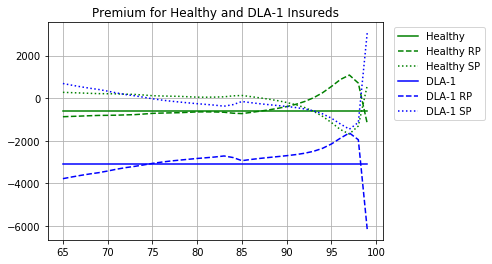

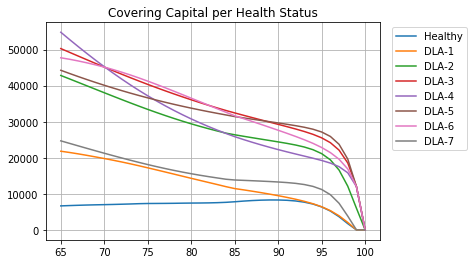

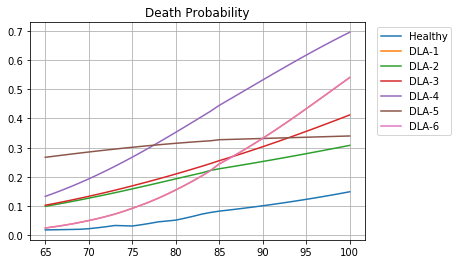

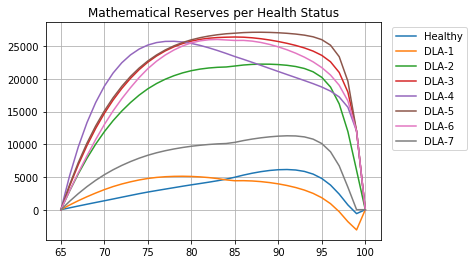

In [4]:
mc_0.plot_premium_split()
mc_0.plot_deckungskapital()
mc_0.plot_pij()
mc_0.plot_mathematical_reserves()

AttributeError: 'MarkovChain' object has no attribute 'plot_mathematical_reserve'

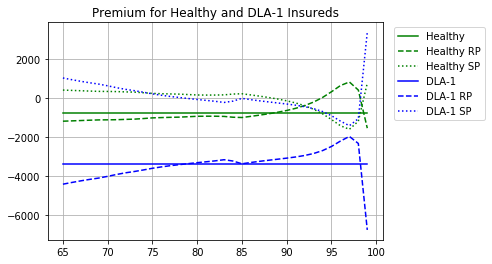

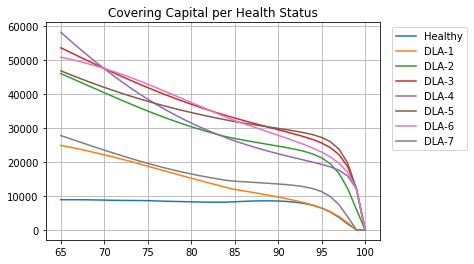

In [5]:
mc_1 = MarkovChain(9, 65, 100, 1)

mc_1.plot_premium_split()
mc_1.plot_deckungskapital()
mc_1.plot_mathematical_reserve()

In [ ]:
mc_2 = MarkovChain(9, 65, 100, 2)

In [ ]:
def plot_mathematical_reserves_difference(mc_0, mc_1, mc_2,  title):
    x = [i for i in range(65, 101, 1)]
    fig, ax = plt.subplots()
    plts = []
    for j in range(1, mc_0.nr_of_states):
        plts.append(ax.plot(x, [mc_1.get_deckungskapital(i, j) - mc_0.get_deckungskapital(i, j) for i in x], '--')[0])
    for j in range(1, mc_0.nr_of_states):
        plts.append(ax.plot(x, [mc_2.get_deckungskapital(i, j) - mc_0.get_deckungskapital(i, j) for i in x], ':')[0])
    ax.grid()
    lgd = ax.legend((p for p in plts),\
                    ('Healthy', 'DLA-1', 'DLA-2', 'DLA-3', 'DLA-4', 'DLA-5', 'DLA-6', 'DLA-7', 'Healthy', 'DLA-1', 'DLA-2', 'DLA-3', 'DLA-4', 'DLA-5', 'DLA-6', 'DLA-7'),\
                    bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_title('Difference in the Mathematical Reserves')
    plt.savefig('mathreservesdifference.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)
    
plot_mathematical_reserves_difference(mc_0, mc_1, mc_2, 'Effect of Single Mortality Reduction')


In [ ]:
def plot_risk_premium(mc_0, mc_1, mc_2):
    x = [i for i in range(65, 101, 1)]
    fig, ax = plt.subplots()
    plts = []
    plts.append(ax.plot(x, [mc_0.risk_premium(i, 1) for i in x], 'g-')[0])
    plts.append(ax.plot(x, [mc_1.risk_premium(i, 1) for i in x], 'g--')[0])
    plts.append(ax.plot(x, [mc_2.risk_premium(i, 1) for i in x], 'g:')[0])
    plts.append(ax.plot(x, [mc_0.risk_premium(i, 2) for i in x], 'b-')[0])
    plts.append(ax.plot(x, [mc_1.risk_premium(i, 2) for i in x], 'b--')[0])
    plts.append(ax.plot(x, [mc_2.risk_premium(i, 2) for i in x], 'b:')[0])
    ax.grid()
    lgd = ax.legend((p for p in plts), ('Helathy Static Model', 'Single Mortality Reduction', 'Double Mortality Reduction',\
                                        'DLA-1 Static Model', 'Single Mortality Reduction', 'Double Mortality Reduction'), bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_title('Risk-premium - Effect of Mortality Reduction')
    plt.savefig('mortalityreductionriskpremium.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

plot_risk_premium(mc_0, mc_1, mc_2)

In [ ]:
def print_risk_premium_increase(mc_0, mc_1, mc_2):
        d={"Age": [i for i in range(65, 101) if i%5 == 0], 
            "Healthy 1X": [mc_1.risk_premium(i, 1) for i in range(65, 101) if i%5 == 0],
            "% diff 1": [mc_1.risk_premium(i, 1) / (mc_0.risk_premium(i, 1) if mc_0.risk_premium(i, 1) != 0 else 1) for i in range(65, 101) if i%5 == 0],
            "Healthy 2X": [mc_2.risk_premium(i, 1) for i in range(65, 101) if i%5 == 0],
            "% diff 2": [mc_2.risk_premium(i, 1) / (mc_0.risk_premium(i, 1) if mc_0.risk_premium(i, 1) != 0 else 1) for i in range(65, 101) if i%5 == 0],
            "DLA-1 1x": [mc_1.risk_premium(i, 2) for i in range(65, 101) if i%5 == 0],
            "% diff 3": [mc_1.risk_premium(i, 2) / (mc_0.risk_premium(i, 2) if mc_0.risk_premium(i, 1) != 0 else 1) for i in range(65, 101) if i%5 == 0],
            "DLA-1 2x": [mc_2.risk_premium(i, 2) for i in range(65, 101) if i%5 == 0],
            "% diff 4": [mc_2.risk_premium(i, 2) / (mc_0.risk_premium(i, 2) if mc_0.risk_premium(i, 2) != 0 else 1) for i in range(65, 101) if i%5 == 0]
          }

        df = pd.DataFrame(d)
        pd.set_option('precision', 2)

        print(df.to_latex(index=False, formatters={
            '% diff 1': '{:.2%}'.format,
            '% diff 2': '{:.2%}'.format,
            '% diff 3': '{:.2%}'.format,
            '% diff 4': '{:.2%}'.format,
        }))
        
print_risk_premium_increase(mc_0, mc_1, mc_2)

In [ ]:
def plot_savings_premium(mc_0, mc_1, mc_2):
    x = [i for i in range(65, 101, 1)]
    fig, ax = plt.subplots()
    plts = []
    plts.append(ax.plot(x, [mc_0.savings_premium(i, 1) for i in x], 'g-')[0])
    plts.append(ax.plot(x, [mc_1.savings_premium(i, 1) for i in x], 'g--')[0])
    plts.append(ax.plot(x, [mc_2.savings_premium(i, 1) for i in x], 'g:')[0])
    plts.append(ax.plot(x, [mc_0.savings_premium(i, 2) for i in x], 'b-')[0])
    plts.append(ax.plot(x, [mc_1.savings_premium(i, 2) for i in x], 'b--')[0])
    plts.append(ax.plot(x, [mc_2.savings_premium(i, 2) for i in x], 'b:')[0])
    ax.grid()
    lgd = ax.legend((p for p in plts), ('Helathy Static Model', 'Single Mortality Reduction', 'Double Mortality Reduction',\
                                        'DLA-1 Static Model', 'Single Mortality Reduction', 'Double Mortality Reduction'), bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_title('Savings-premium - Effect of Mortality Reduction')
    plt.savefig('mortalityreductionsavingspremium.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

plot_savings_premium(mc_0, mc_1, mc_2)

In [ ]:
def plot_premium(mc_0, mc_1, mc_2):
    x = [i for i in range(65, 101, 1)]
    fig, ax = plt.subplots()
    plts = []
    plts.append(ax.plot(x, [mc_0.premium(i, 1) for i in x], 'g-')[0])
    plts.append(ax.plot(x, [mc_1.premium(i, 1) for i in x], 'g--')[0])
    plts.append(ax.plot(x, [mc_2.premium(i, 1) for i in x], 'g:')[0])
    plts.append(ax.plot(x, [mc_0.premium(i, 2) for i in x], 'b-')[0])
    plts.append(ax.plot(x, [mc_1.premium(i, 2) for i in x], 'b--')[0])
    plts.append(ax.plot(x, [mc_2.premium(i, 2) for i in x], 'b:')[0])
    ax.grid()
    lgd = ax.legend((p for p in plts), ('Helathy Static Model', 'Single Mortality Reduction', 'Double Mortality Reduction',\
                                        'DLA-1 Static Model', 'Single Mortality Reduction', 'Double Mortality Reduction'), bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_title('Total Premium - Effect of Mortality Reduction')
    plt.savefig('mortalityreductionpremium.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

plot_premium(mc_0, mc_1, mc_2)

In [ ]:
mc_woman_1 = MarkovChain(9, 65, 100, 1, 1)
mc_woman_2 = MarkovChain(9, 65, 100, 2, 1)

def plot_premium_healthy_men_women(mc_0, mc_1, mc_woman_1, mc_2, mc_woman_2):
    x = [i for i in range(65, 101, 1)]
    fig, ax = plt.subplots()
    plts = []
    plts.append(ax.plot(x, [mc_0.premium(i, 1) for i in x], 'g-')[0])
    plts.append(ax.plot(x, [mc_1.premium(i, 1) for i in x], 'g--')[0])
    plts.append(ax.plot(x, [mc_2.premium(i, 1) for i in x], 'g:')[0])
    plts.append(ax.plot(x, [mc_woman_1.premium(i, 1) for i in x], 'r.')[0])
    plts.append(ax.plot(x, [mc_woman_2.premium(i, 1) for i in x], 'r-.')[0])
    ax.grid()
    lgd = ax.legend((p for p in plts), ('Static Model', 'Single Mortality Reduction - Men', 'Double Mortality Reduction - Men', 'Single Mortality Reduction - Women', 'Double Mortality Reduction - Women'),\
                    bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_title('Total Premium - Healthy Insured')
    plt.savefig('healthymanwomancomparison.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

plot_premium_healthy_men_women(mc_0, mc_1, mc_woman_1, mc_2, mc_woman_2)


In [ ]:
def plot_premium_dla_men_women(mc_0, mc_1, mc_woman_1, mc_2, mc_woman_2):
    x = [i for i in range(65, 101, 1)]
    fig, ax = plt.subplots()
    plts = []
    plts.append(ax.plot(x, [mc_0.premium(i, 2) for i in x], 'b-')[0])
    plts.append(ax.plot(x, [mc_1.premium(i, 2) for i in x], 'b--')[0])
    plts.append(ax.plot(x, [mc_2.premium(i, 2) for i in x], 'b:')[0])
    plts.append(ax.plot(x, [mc_woman_1.premium(i, 2) for i in x], 'r.')[0])
    plts.append(ax.plot(x, [mc_woman_2.premium(i, 2) for i in x], 'r-.')[0])
    ax.grid()
    lgd = ax.legend((p for p in plts), ('Static Model', 'Single Mortality Reduction - Men', 'Double Mortality Reduction - Men', 'Single Mortality Reduction - Women', 'Double Mortality Reduction - Women'),\
                    bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_title('Total Premium - DLA-1 Insured')
    plt.savefig('dlamanwomancomparison.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

plot_premium_dla_men_women(mc_0, mc_1, mc_woman_1, mc_2, mc_woman_2)

In [ ]:
def print_risk_premium_increase(mc_0, mc_1, mc_2):
        d={"Age": [i for i in range(65, 101) if i%5 == 0], 
            "Saving premium": [mc_1.savings_premium(i, 1) / (mc_0.savings_premium(i, 1) if mc_0.savings_premium(i, 1) != 0 else 1) for i in range(65, 101) if i%5 == 0],
            "% diff 1": [mc_1.risk_premium(i, 1) / (mc_0.risk_premium(i, 1) if mc_0.risk_premium(i, 1) != 0 else 1) for i in range(65, 101) if i%5 == 0],
            "Healthy 2X": [mc_2.risk_premium(i, 1) for i in range(65, 101) if i%5 == 0],
            "% diff 2": [mc_2.risk_premium(i, 1) / (mc_0.risk_premium(i, 1) if mc_0.risk_premium(i, 1) != 0 else 1) for i in range(65, 101) if i%5 == 0],
            "DLA-1 1x": [mc_1.risk_premium(i, 2) for i in range(65, 101) if i%5 == 0],
            "% diff 3": [mc_1.risk_premium(i, 2) / (mc_0.risk_premium(i, 2) if mc_0.risk_premium(i, 1) != 0 else 1) for i in range(65, 101) if i%5 == 0],
            "DLA-1 2x": [mc_2.risk_premium(i, 2) for i in range(65, 101) if i%5 == 0],
            "% diff 4": [mc_2.risk_premium(i, 2) / (mc_0.risk_premium(i, 2) if mc_0.risk_premium(i, 2) != 0 else 1) for i in range(65, 101) if i%5 == 0]
          }

        df = pd.DataFrame(d)
        pd.set_option('precision', 2)

        print(df.to_latex(index=False, formatters={
            '% diff 1': '{:.2%}'.format,
            '% diff 2': '{:.2%}'.format,
            '% diff 3': '{:.2%}'.format,
            '% diff 4': '{:.2%}'.format,
        }))
        
print_risk_premium_increase(mc_0, mc_1, mc_2)

In [ ]:
#loss quotient
np.exp(-mc_0.mortality_reduction(65, 0) * 10)